# My Recommendation mini framework

The goal of this practical session is to set up a basic recommendation framework to load, run an algorithm, and evaluate it. Your framework should be generic enough to be able to interface with scikit-learn, surprise, and Microsoft Recommenders that will be used later in this course.

## Data loading and exploration

We will work with Movie Lens 100k dataset. The dataset is available online. You can either load it by hand or use surprise to load it. Be careful, surprise has a non-trivial dataset definition that may be confusing for you.

In [7]:
import numpy as np
from surprise import Dataset
import pandas as pd
from surprise.model_selection import train_test_split

ml100k = Dataset.load_builtin('ml-100k')
trainset, testset = train_test_split(ml100k, test_size=.30)

pandas_ml100k = pd.DataFrame(ml100k.raw_ratings, columns =['userid', 'movieid', 'rates', 'timestamps'] )
print("Miam !")

Miam !


# Explore the dataset
Now that you have loaded the dataset, **and before doing anything else**, we want to have some insight about it. Compute at minima the following statistics:
* distribution of ratings per user
* distribution of ratings per movie
* mean / median / stddev / quantiles for all measures
* density

Your plots must be clear and readable.

*Hint: you can take a look at pandas for handy functions*

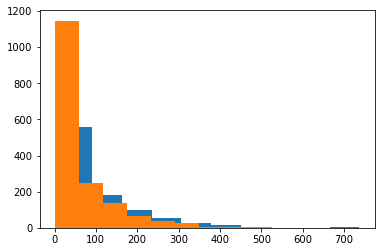

3.52986 1.1256679707622492 [1. 3. 4. 4. 5.]


In [61]:
%matplotlib inline
from matplotlib import pyplot as plt

train = ml100k.build_full_trainset()
users = train.ur
films = train.ir
nbrating_per_user = []
nbrating_per_film = []

for userid,filmlist in users.items():
    nbrating_per_user.append(len(filmlist))
    
for filmid,userlist in films.items():
    nbrating_per_film.append(len(userlist))

    
plt.hist(nbrating_per_user)
plt.hist(nbrating_per_film)
plt.show()

ratings = pandas_ml100k['rates'].values
means = ratings.mean()
std = ratings.std()
quantiles = np.quantile(ratings, [0,0.25,0.5,0.75,1], axis=0)
print(means, std, quantiles)

In [ ]:
'''
Les gens ont tendance à noter entre 3 et 4.
66% des valeurs sont comprise par definition entre moyenne +- std, càd entre environs 2.4 et 4.6
25% de la population donne des notes inferieures à 3.

Les gens laisse en général moins de 100 notes. (grossiérement)

On peut facilement produire plus de métriques et préciser les choses. 
'''

One you have your plots, update this cell with the interpretations that will guide your algorithm development.

## Build your first algorithm

It is time to build a naive algorithm in order to test your recommendation framework. All the mentioned framework follow the same scikit-learn estimator convention. You can read it here: https://scikit-learn.org/stable/developers/contributing.html#estimators

Basically, your estimator should:
- have an `__init__` function where its parameters are set
- have a `fit` function that takes the training dataset in parameter and learn the algorithm
- have a `predict` function that takes a sample (userid + movieid) as parameter and predict a rating

In [4]:
from surprise import prediction_algorithms
from surprise import SVD

class Recommendation:
    def __init__(self, model):
        self.model = model
    def fit(self, trainset):
        return self.model.fit(trainset)
    def predict(self, testset):
        return self.model.test(testset)
        

In [5]:
r = Recommendation(SVD())
"""
On aurait pu faire plus simple.
Genre random ou quoi ...
Bon j'avoue je suis un peu un escroc, mais comme ça on a appris à 'utiliser' surprise à moindre coût.
"""
r.fit(trainset)
pred = r.predict(testset)

## Build a validation process

Here, you should use all of your previous functions to split your dataset in train and test set, do a prediction, and estimate the value of your algorithm on unseen data.

The way you do it (number of splits...) is up to you. You should use the metrics that are the most adapted to the problem according to you. Do not hesitate to motivate your choice using comments or a Markdown cell.

In [19]:
from collections import defaultdict

def top_pred(predictions):
    #idée trouvé dans un tuto
    #Trie les predictions par note
    
    top = defaultdict(list)
    for userid, movieid, true_r, est_r, _ in predictions:
        top[userid].append((movieid, est_r))
    
    top = dict(
        map(lambda user_ratings : (user_ratings[0], 
                                   sorted(user_ratings[1], key=lambda film_rating: film_rating[1], reverse=True)),
            top.items())
    ) 
    # Voilà qui plus jolie mais fait des copies :'(
    
#     for userid, user_ratings in top.items():
#         user_ratings.sort(key=lambda x: x[1], reverse=True)
#         top[userid] = user_ratings

    return top

def test_pred(pred, seuil): #une horrible fonction pour compter les valeurs correctement prédites
    count_sucess = 0
    for p in pred:
        if  p.est - seuil < p.r_ui and  p.r_ui < p.est + seuil:
            count_sucess +=1 
    return count_sucess / len(pred) * 100

top = top_pred(pred)
print("La justesse est de {}%".format(round(test_pred(pred, 0.5)))) # c'est moyen +. On peut reflechir a une meilleur fonction de test
random_user_id = np.random.choice(tuple(set(top.keys())),1)[0]
print(top[random_user_id][:10]) #les 10 premiers qui seront un page d'acceuil pour l'utilisateur random_user_id


La justesse est de 41%
[('185', 4.776140845482739), ('12', 4.715803258251672), ('183', 4.655446930312151), ('59', 4.601170771866371), ('302', 4.496122603559604), ('427', 4.483839064637371), ('180', 4.473567886592904), ('182', 4.471870574196748), ('1070', 4.454531156544236), ('223', 4.38965191629115)]
